<a href="https://colab.research.google.com/github/Falconwatch/BankingBattle/blob/main/Investments/HW2/Investments_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Не понятные вопросы:
0) В анализе голубых фишек нужно учитывать только те ордеры, которые закончились сделкой?

1) Как считать daily volatility: по всем успешным buy или групировать buy по сделкам(TradeNo) и считать между сделками?

2) Как считать bid-ask spread? здесь нужно учитывать не только состоявшиеся сделки?

In [101]:
from os import listdir
from os.path import isfile, join
import tqdm
import pandas as pd
import polars as ps
from zipfile import ZipFile
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, time, timedelta
from google.colab import drive

In [2]:
drive.mount('/content/drive')
path_to_folder_with_files = "/content/drive/MyDrive/NES/investments/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Необходимые переменные для будущих частей

In [3]:
#количество файлов, для обработки (будет обработано н еболее чем)
FILES_TO_PROCESS=5

In [4]:
blue_chips = ["CHMF", "GAZP", "GMKN", "IRAO", "LKOH", "MGNT", "MTSS", "NVTK", "PLZL", "ROSN", "RUAL","SEBR","SNGS","TATN", "YNDX"]
blue_chips_data = {}

# Первая часть - изучение данных

In [5]:
onlyfiles = [f for f in listdir(path_to_folder_with_files) if isfile(join(path_to_folder_with_files, f))]
datas = {f[10:-4]:{"file":f} for f in onlyfiles[:FILES_TO_PROCESS]}

## Explore data
To explore the data, in a table for each day for each field summarize relevant information,
for example, type of the field, min value, max value, number of NA and missing values etc.

In [6]:
def read_one_day(filename):
  oneday = ps.read_csv(ZipFile(path_to_folder_with_files+filename).read(filename[:-3]+"txt"),
                 null_values=["-"])
  gc.collect()
  return oneday

In [7]:
one_day_example = read_one_day(datas["231005"]["file"])

In [60]:
one_day_example

SECCODE,BUYSELL,TIME,TRADENO,PRICE,VOLUME
str,str,i64,i64,f64,i64
"""BISVP""","""B""",100000002676,null,15.08,500
"""BISVP""","""S""",100000002676,null,15.2,1200
"""FEES""","""B""",100000002768,8560608534,0.11842,10000
"""FEES""","""B""",100000002768,null,0.12606,1000000
"""FEES""","""S""",100000002768,null,0.1182,50000
…,…,…,…,…,…
"""VGSBP""","""S""",235900000000,null,13.635,2000
"""YRSBP""","""S""",235900000000,null,370.5,420
"""HMSG""","""S""",235900000000,null,248.0,250


## Filtered obs
In one consolidated table summarize information on filtered out observations for each
type of errors (missing data, NAs, duplicate, bad data etc.) for each data field: how many
observations were deleted due to these errors.

In [9]:
def get_int_columns_stats(df, column):

  if df[column].dtype.is_numeric():
    column_stats = df.select(
         ps.when(ps.col(column).is_nan()).then(1).otherwise(0).sum().alias("nans"),
         ps.when(ps.col(column).is_null()).then(1).otherwise(0).sum().alias("nulls"),
         ps.when(ps.col(column)<0).then(1).otherwise(0).sum().alias("bellow_zero"),
         ps.when(ps.col(column)>0).then(1).otherwise(0).sum().alias("above_zero"),
         ps.when(ps.col(column)==0).then(1).otherwise(0).sum().alias("equal_zero"))
  else:
    column_stats = df.select(
          ps.when(ps.col(column).is_null()).then(1).otherwise(0).sum().alias("nulls"))
  return column_stats.to_dicts()[0]

def describe_bad_data(df, date):
  price_stats = get_int_columns_stats(df, "PRICE")
  volume_stats = get_int_columns_stats(df, "VOLUME")
  time_stats = get_int_columns_stats(df, "TIME")
  seccode_stats = get_int_columns_stats(df, "SECCODE")
  buysell_stats = get_int_columns_stats(df, "BUYSELL")
  tradeno_stats = get_int_columns_stats(df, "TRADENO")

  if "cleaning" not in datas[date]:
    datas[date]["cleaning"]={}
  datas[date]["cleaning"]["price"] = price_stats
  datas[date]["cleaning"]["volume"] = volume_stats
  datas[date]["cleaning"]["time"] = time_stats
  datas[date]["cleaning"]["seccode"] = seccode_stats
  datas[date]["cleaning"]["buysell"] = buysell_stats
  datas[date]["cleaning"]["tradeno"] = tradeno_stats



#Excludes bad observations, for example, transactions with price or size of 0.
def clean_zeros(df, date):
  df_ok = df.filter((ps.col("PRICE")>0) & (ps.col("VOLUME")>0))
  deleted_zeros = df.shape[0] - df_ok.shape[0]
  if "cleaning" not in datas[date]:
    datas[date]["cleaning"]={}
  datas[date]["cleaning"]["deleted_zeros"] = deleted_zeros
  return df_ok


#Excludes observations out of main trading hours 9:50–18:50.
def clear_time(df, date):
  df_ok = df.filter((ps.col("TIME")>=95000000000) & (ps.col("TIME")<=185000000000))
  out_of_time = df.shape[0] - df_ok.shape[0]
  if "cleaning" not in datas[date]:
    datas[date]["cleaning"]={}
  datas[date]["cleaning"]["out_of_time"] = out_of_time
  return df_ok


# Deals with NAs in the data if any.
def clear_nas(df, date,
              columns_to_check = ['SECCODE', 'BUYSELL', 'TIME', 'PRICE', 'VOLUME']):
  df_ok = df.drop_nulls(subset=columns_to_check)
  #df_ok = df.drop_nulls()
  dropped_nans = df.shape[0] - df_ok.shape[0]
  if "cleaning" not in datas[date]:
    datas[date]["cleaning"]={}
  datas[date]["cleaning"]["dropped_nans"] = dropped_nans
  return df_ok

#If there are any duplicates, exclude them as well.
def clean_duplicates(df, date):
  df_ok = df.unique(subset=df.columns)
  dropped_duplicates = df.shape[0] - df_ok.shape[0]
  if "cleaning" not in datas[date]:
    datas[date]["cleaning"]={}
  datas[date]["cleaning"]["dropped_duplicates"] = dropped_duplicates
  return df_ok

In [10]:
for date in tqdm.tqdm(datas.keys()):

  oneday_df = read_one_day(datas[date]["file"])
  #собираю статистику
  describe_bad_data(oneday_df, date)

  oneday_df = clean_zeros(oneday_df, date) # удаляю нулевые транзакции
  oneday_df = clear_nas(oneday_df, date) # удаляю где есть пустоты
  oneday_df = clear_time(oneday_df, date) # удаляю вне времени торговли
  oneday_df = clean_duplicates(oneday_df, date) # удаляю дубликаты
  blue_chips_data[date] = oneday_df.filter(ps.col("SECCODE").is_in(blue_chips)) #сохраняю данные для второй части
  del oneday_df
  gc.collect()


100%|██████████| 5/5 [02:40<00:00, 32.16s/it]


In [11]:
all_stats = [(k, v["cleaning"]) for k,v in datas.items()]
for i in range(len(all_stats)):
  all_stats[i][1]["date"] = all_stats[i][0]
all_stats = [a[1] for a in all_stats]

all_stats_pd = pd.json_normalize(all_stats)

In [12]:
all_stats_pd

,deleted_zeros,dropped_nans,out_of_time,dropped_duplicates,date,price.nans,price.nulls,price.bellow_zero,price.above_zero,price.equal_zero,...,time.bellow_zero,time.above_zero,time.equal_zero,seccode.nulls,buysell.nulls,tradeno.nans,tradeno.nulls,tradeno.bellow_zero,tradeno.above_zero,tradeno.equal_zero
0,787,0,11642,771,231005,0,787,0,17611206,0,...,0,17611993,0,0,0,0,12234044,0,5377949,0
1,6722,0,19868,1260,231013,0,6722,0,17705095,0,...,0,17711817,0,0,0,0,11883185,0,5828632,0
2,1949,0,17744,2650,231020,0,1949,0,18128944,0,...,0,18130893,0,0,0,0,11776417,0,6354476,0
3,3557,0,18507,1381,231019,0,3557,0,18149038,0,...,0,18152595,0,0,0,0,11768488,0,6384107,0
4,5686,0,12854,1344,231027,0,5686,0,24245841,0,...,0,24251527,0,0,0,0,17511908,0,6739619,0


# Analysis of blue-chip stocks


In [13]:
for k in blue_chips_data.keys():
  blue_chips_data[k] = blue_chips_data[k].with_columns(ps.lit(k).alias("date"))
all_blue_chips_data = ps.concat(blue_chips_data.values())

In [14]:
all_blue_chips_data\
  .filter((ps.col("SECCODE")=="NVTK") & (ps.col("date")=="231013"))\
  .filter(ps.col("TRADENO").is_not_null())\
.sort("TIME").group_by("BUYSELL").agg(ps.col("VOLUME").sum())

BUYSELL,VOLUME
str,i64
"""B""",374268
"""S""",374268


In [15]:
def find_daily_volatility(group_series):
  group_df = ps.DataFrame(group_series, schema=["TIME", "PRICE"])

  agg = group_df\
    .sort(["TIME"])\
    .with_columns(
        (ps.col("PRICE")/ps.col("PRICE").shift()).log().pow(2).alias("p_diff_log_sq")
        )\
    .select(
        ps.col("p_diff_log_sq").sum().pow(0.5).alias("daily_volatility"),
        )
  return agg["daily_volatility"][0]

def find_quotes_changes(group_series):
  group_df = ps.DataFrame(group_series, schema=["TIME", "PRICE"])

  agg = group_df\
    .sort(["TIME"])\
    .with_columns(
        (ps.col("PRICE")/ps.col("PRICE").shift()).alias("p_diff")
        )\
    .select(
        ps.when(ps.col("p_diff")==1).then(0).otherwise(1).sum().alias("quotes_changes")
        )
  return agg["quotes_changes"][0]

def calc_daily_stats(df):
  daily_stats = df.group_by(["SECCODE", "date"])\
  .agg(
    (ps.col("VOLUME")*ps.col("PRICE")).sum().alias("daily_total_rubble_volume"),
    (ps.col("VOLUME")*ps.col("PRICE")).mean().alias("daily_avg_rubble_volume"),
    (ps.col("VOLUME")*ps.col("PRICE")).median().alias("daily_median_rubble_volume"),

    ps.col("VOLUME").sum().alias("daily_total_volume"),
    ps.col("VOLUME").mean().alias("daily_avg_volume"),
    ps.col("VOLUME").median().alias("daily_median_volume"),

    ps.col("PRICE").mean().alias("daily_avg_price"),
    ps.col("TRADENO").count().alias("daily_transactions"),

    ps.map_groups(
        exprs=[ "TIME", "PRICE"],
        function=find_daily_volatility).alias("daily_volatility"),
    ps.map_groups(
        exprs=[ "TIME", "PRICE"],
        function=find_quotes_changes).alias("daily_quotes_changes"),
  )\
  .with_columns((ps.col("daily_total_rubble_volume")/ps.col("daily_total_volume")).alias("daily_avg_weighted_price"))\
  .sort(["SECCODE", "date"])
  return daily_stats

daily_stats_BUY = calc_daily_stats(all_blue_chips_data.filter(ps.col("BUYSELL")=="B").filter(ps.col("TRADENO").is_not_null()))
daily_stats_SELL = calc_daily_stats(all_blue_chips_data.filter(ps.col("BUYSELL")=="S").filter(ps.col("TRADENO").is_not_null()))

## 5. Answer the following questions:
a) Which stock was the most/least volatile during the period under investigation?

b) Which stock had the largest/lowest share volume? ruble volume?

c) Which stock had the largest/lowest number of transactions?

d) Which stock had the largest/lowest number of quotes changes?

e) On which day of the week stocks had the largest/lowest volume in the sample?

f) Which stock had the highest/lowest ruble bid-ask spread? percentage bid-ask
spread?

### a) Which stock was the most/least volatile during the period under investigation?

In [16]:
#Which stock was the most/least volatile during the period under investigation?
mean_daily_volatility = daily_stats_BUY.group_by("SECCODE").agg(ps.col("daily_volatility").mean().alias("mean_daily_volatility"))\
.sort("mean_daily_volatility")
print(mean_daily_volatility[0])
print(mean_daily_volatility[-1])

shape: (1, 2)
┌─────────┬───────────────────────┐
│ SECCODE ┆ mean_daily_volatility │
│ ---     ┆ ---                   │
│ str     ┆ f64                   │
╞═════════╪═══════════════════════╡
│ NVTK    ┆ 0.022744              │
└─────────┴───────────────────────┘
shape: (1, 2)
┌─────────┬───────────────────────┐
│ SECCODE ┆ mean_daily_volatility │
│ ---     ┆ ---                   │
│ str     ┆ f64                   │
╞═════════╪═══════════════════════╡
│ YNDX    ┆ 0.069711              │
└─────────┴───────────────────────┘


### b) Which stock had the largest/lowest share volume? ruble volume?

In [17]:
# Which stock had the largest/lowest share volume? ruble volume?
volumes = daily_stats_SELL.group_by("SECCODE")\
  .agg(
        ps.col("daily_total_volume").sum().alias("total_volume"),
        ps.col("daily_total_rubble_volume").sum().alias("total_rubble_volume")
      )
#share volume
print("share volume")
print(volumes.sort("total_volume").select("total_volume")[0])
print(volumes.sort("total_volume").select("total_volume")[-1])
print("####################################################")

#ruble volume
print("ruble volume")
print(volumes.sort("total_rubble_volume").select("total_rubble_volume")[0])
print(volumes.sort("total_rubble_volume").select("total_rubble_volume")[-1])

share volume
shape: (1, 1)
┌──────────────┐
│ total_volume │
│ ---          │
│ i64          │
╞══════════════╡
│ 282699       │
└──────────────┘
shape: (1, 1)
┌──────────────┐
│ total_volume │
│ ---          │
│ i64          │
╞══════════════╡
│ 355577000    │
└──────────────┘
####################################################
ruble volume
shape: (1, 1)
┌─────────────────────┐
│ total_rubble_volume │
│ ---                 │
│ f64                 │
╞═════════════════════╡
│ 1.4718e9            │
└─────────────────────┘
shape: (1, 1)
┌─────────────────────┐
│ total_rubble_volume │
│ ---                 │
│ f64                 │
╞═════════════════════╡
│ 3.8162e10           │
└─────────────────────┘


### c) Which stock had the largest/lowest number of transactions?

In [18]:
# c) Which stock had the largest/lowest number of transactions?
transactions = daily_stats_SELL.group_by("SECCODE")\
  .agg(
        ps.col("daily_transactions").sum().alias("total_transactions"),
      )
print(transactions.sort("total_transactions")[0])
print(transactions.sort("total_transactions")[-1])

shape: (1, 2)
┌─────────┬────────────────────┐
│ SECCODE ┆ total_transactions │
│ ---     ┆ ---                │
│ str     ┆ u32                │
╞═════════╪════════════════════╡
│ MTSS    ┆ 35357              │
└─────────┴────────────────────┘
shape: (1, 2)
┌─────────┬────────────────────┐
│ SECCODE ┆ total_transactions │
│ ---     ┆ ---                │
│ str     ┆ u32                │
╞═════════╪════════════════════╡
│ YNDX    ┆ 380689             │
└─────────┴────────────────────┘


### d) Which stock had the largest/lowest number of quotes changes?

In [19]:
# d) Which stock had the largest/lowest number of quotes changes?
quotes_changes = daily_stats_SELL.group_by("SECCODE")\
  .agg(
        ps.col("daily_quotes_changes").sum().alias("total_quotes_changes"),
      )
print(quotes_changes.sort("total_quotes_changes")[0])
print(quotes_changes.sort("total_quotes_changes")[-1])

shape: (1, 2)
┌─────────┬──────────────────────┐
│ SECCODE ┆ total_quotes_changes │
│ ---     ┆ ---                  │
│ str     ┆ i64                  │
╞═════════╪══════════════════════╡
│ MTSS    ┆ 15792                │
└─────────┴──────────────────────┘
shape: (1, 2)
┌─────────┬──────────────────────┐
│ SECCODE ┆ total_quotes_changes │
│ ---     ┆ ---                  │
│ str     ┆ i64                  │
╞═════════╪══════════════════════╡
│ YNDX    ┆ 189737               │
└─────────┴──────────────────────┘


### e) On which day of the week stocks had the largest/lowest volume in the sample?

In [20]:
# e) On which day of the week stocks had the largest/lowest volume in the sample?
volume_on_date = daily_stats_SELL.group_by("date")\
  .agg(ps.col("daily_total_rubble_volume").sum().alias("date_total_rubble_volume"),
       ps.col("daily_total_volume").sum().alias("date_total_volume"))
volume_on_date = volume_on_date.with_columns(ps.col("date").str.to_date(format="%y%m%d").dt.weekday().alias("weekday"))

volume_on_wd = volume_on_date.group_by("weekday")\
  .agg(
      ps.col("date_total_volume").sum().alias("weekday_total_volume"),
      ps.col("date_total_rubble_volume").sum().alias("weekday_total_rubble_volume"),
                                       )
volume_on_wd


#share volume
print("weekday volume")
print(volume_on_wd.sort("weekday_total_volume").select("weekday_total_volume")[0])
print(volume_on_wd.sort("weekday_total_volume").select("weekday_total_volume")[-1])
print("####################################################")

#ruble volume
print("weekday ruble volume")
print(volume_on_wd.sort("weekday_total_rubble_volume").select("weekday_total_rubble_volume")[0])
print(volume_on_wd.sort("weekday_total_rubble_volume").select("weekday_total_rubble_volume")[-1])

weekday volume
shape: (1, 1)
┌──────────────────────┐
│ weekday_total_volume │
│ ---                  │
│ i64                  │
╞══════════════════════╡
│ 328527967            │
└──────────────────────┘
shape: (1, 1)
┌──────────────────────┐
│ weekday_total_volume │
│ ---                  │
│ i64                  │
╞══════════════════════╡
│ 445329212            │
└──────────────────────┘
####################################################
weekday ruble volume
shape: (1, 1)
┌─────────────────────────────┐
│ weekday_total_rubble_volume │
│ ---                         │
│ f64                         │
╞═════════════════════════════╡
│ 4.9757e10                   │
└─────────────────────────────┘
shape: (1, 1)
┌─────────────────────────────┐
│ weekday_total_rubble_volume │
│ ---                         │
│ f64                         │
╞═════════════════════════════╡
│ 9.1859e10                   │
└─────────────────────────────┘


### f) Which stock had the highest/lowest ruble bid-ask spread? percentage bid-ask spread?

In [21]:
# f) Which stock had the highest/lowest ruble bid-ask spread? percentage bid-ask spread?
spreads = all_blue_chips_data\
.filter(ps.col("TRADENO").is_null())\
.with_columns(ps.when(ps.col("BUYSELL")=="B").then(ps.col("PRICE")).otherwise(None).alias("buy_price"),
              ps.when(ps.col("BUYSELL")=="S").then(ps.col("PRICE")).otherwise(None).alias("sell_price"))\
.group_by("SECCODE", "date", "TIME")\
.agg(ps.col("buy_price").max().alias("best_buy"),
     ps.col("sell_price").min().alias("best_sell"))\
.with_columns((ps.col("best_sell") - ps.col("best_buy")).alias("spread"))\
.with_columns((100*ps.col("spread")/ps.col("best_sell")).alias("spread_perc"))\
.with_columns((ps.col("spread")>0).alias("spread_positive"))\
.filter(ps.col("spread").is_not_null())

spreads.filter(ps.col("spread")>0).group_by("SECCODE").agg(ps.col("spread").max())\
.sort("spread", descending=True)[:3]

SECCODE,spread
str,f64
"""YNDX""",22.4
"""GMKN""",22.0
"""PLZL""",21.5


In [22]:
spreads.filter(ps.col("spread_perc")>0).group_by("SECCODE").agg(ps.col("spread_perc").max())\
.sort("spread_perc", descending=True)[:3]

SECCODE,spread_perc
str,f64
"""YNDX""",0.820934
"""CHMF""",0.502959
"""RUAL""",0.4914


## 6) Examine empirically what is the relationship between the number of trades and thenumber of quotes changes? For example, plot the log of the number of trades against the log of the number of quotes changes calculated for each stock and each trading day.

<Axes: xlabel='trades_count_log', ylabel='daily_quotes_changes_log'>

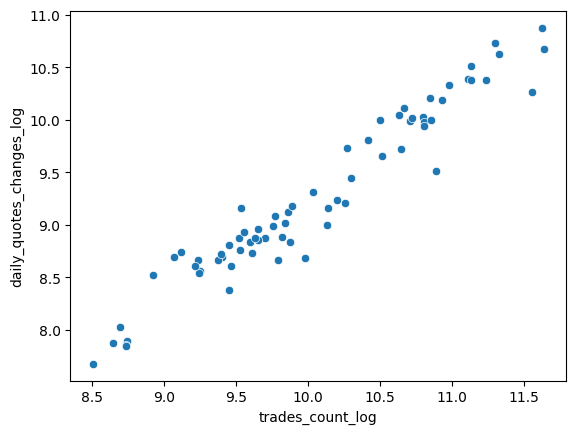

In [23]:
trades_count = all_blue_chips_data\
.filter(ps.col("BUYSELL")=="B")\
.filter(ps.col("TRADENO").is_not_null())\
.group_by("date", "SECCODE")\
.agg(ps.col("TRADENO").n_unique().log().alias("trades_count_log"))

daily_quotes_changes = daily_stats_BUY.select("SECCODE", "date",
                                              ps.col("daily_quotes_changes").log().alias("daily_quotes_changes_log"))
changes_vs_trades = trades_count.join(daily_quotes_changes, on =["SECCODE", "date"])

sns.scatterplot(data = changes_vs_trades, x="trades_count_log", y="daily_quotes_changes_log")

## 7) Trading volume often exhibits specific intraday patterns. Examine intraday patterns in volume by calculating the average ruble volume executed during each 30-min period between 9:50 and 18:50; see figure 10 in example. Stocks differ a lot by volume. To aggregate data across 15 stocks into one chart, you may plot, for example, the typical fraction of daily volume executed during each thirty-minute interval (and then averaged across all stocks). How would you suggest to treat the first and the last intervals given that they are shorter than the rest of intervals?

In [34]:
def str_to_time(examp):
  micro = int(examp[-6:])
  ss = int(examp[-8:-6])
  mm = int(examp[-10:-8])
  hh = int(examp[:-10])
  delta = timedelta(hours=hh, minutes=mm, seconds=ss, microseconds=micro)
  return delta.total_seconds()


In [68]:
str_to_time("101000000000")//1800

20.0

In [44]:
all_blue_chips_data = all_blue_chips_data.with_columns(ps.col("TIME").map_elements(lambda x: str_to_time(str(x)),
                                                             return_dtype=float).alias("TIME_secs"))

In [48]:
data_for_hh_analysis =\
all_blue_chips_data\
.with_columns((ps.col("TIME_secs") // 1800).alias("hh"))\
.filter(ps.col("TRADENO").is_not_null())\
.filter(ps.col("BUYSELL")=="B")\
.group_by("date", "hh", "SECCODE")\
.agg(ps.col("VOLUME").sum().alias("hh_volume"))\
.sort("date", "hh", "SECCODE")

data_for_hh_analysis_daily =\
data_for_hh_analysis\
.group_by("date","SECCODE")\
.agg(ps.col("hh_volume").sum().alias("hh_volume_daily"))

data_for_hh_analysis_predfinal = data_for_hh_analysis.join(data_for_hh_analysis_daily,
                                                       on=["date", "SECCODE"])\
.with_columns((ps.col("hh_volume")/ps.col("hh_volume_daily")).alias("hh_fraction"))
data_for_hh_analysis_predfinal.head()

date,hh,SECCODE,hh_volume,hh_volume_daily,hh_fraction
str,f64,str,i64,i64,f64
"""231005""",20.0,"""CHMF""",44668,473883,0.09426
"""231005""",20.0,"""GAZP""",1457750,13210340,0.110349
"""231005""",20.0,"""GMKN""",4142,43211,0.095855
"""231005""",20.0,"""IRAO""",11461000,56766300,0.201898
"""231005""",20.0,"""LKOH""",120356,621074,0.193787


In [99]:

hh_fraction_for_plot = data_for_hh_analysis_predfinal.group_by("hh")\
.agg(ps.col("hh_fraction").mean().alias("fraction"))\
.sort("hh")

<ipython-input-106-2823b7bde9f4>:8: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  hh_fraction_for_plot = hh_fraction_for_plot.with_columns(ps.col("hh")\


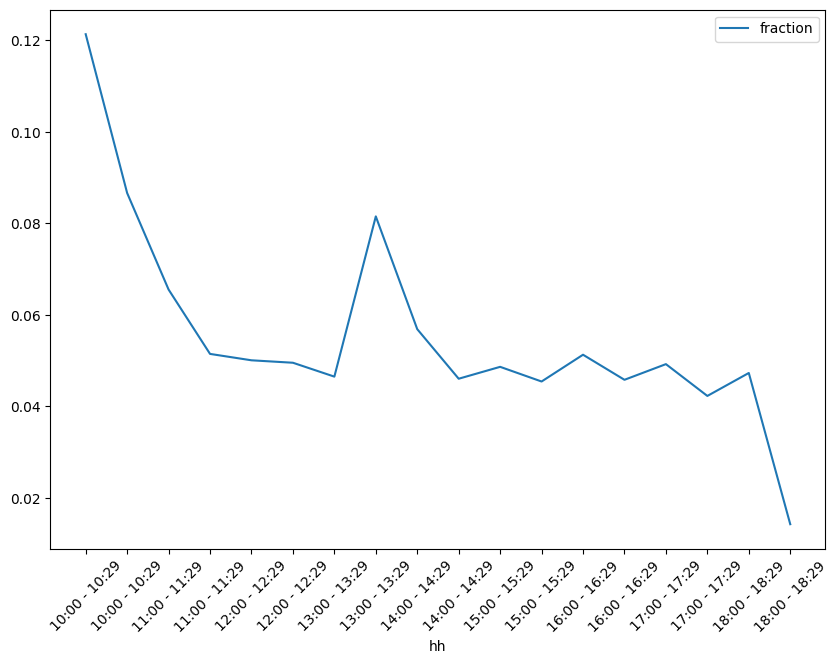

In [106]:

def hh_to_str(hh):
  hour = int(hh*1800/60/60)
  if hh%1 == 0:
    return f"{hour}:00 - {hour}:29"
  else:
    return f"{hour}:30 - {hour}:59"

hh_fraction_for_plot = hh_fraction_for_plot.with_columns(ps.col("hh")\
                                                         .map_elements(lambda x: hh_to_str(x)).alias("hh_str"))
ax = hh_fraction_for_plot.to_pandas().set_index("hh").drop("hh_str", axis=1).plot(figsize=[10,7])
_ = ax.set_xticks(hh_fraction_for_plot["hh"])
_ = ax.set_xticklabels(hh_fraction_for_plot["hh_str"], rotation=45)
#ax.set_xticks(hh_fraction_for_plot["hh_str"],)